### importing

In [78]:
import os
import pandas as pd

# Define the directory path where your data is stored
data_dir = 'op_spam_v1.4/negative_polarity'

# Initialize empty lists to store data
reviews = []
labels = []
folds = []

# Loop through each fold
for fold in range(1, 6):
    
    # Read negative truthful reviews
    truthful_dir = os.path.join(data_dir, 'deceptive_from_MTurk', f'fold{fold}')
    for file in os.listdir(truthful_dir):
        with open(os.path.join(truthful_dir, file), 'r', encoding='utf-8') as f:
            review = f.read()
            reviews.append(review)
            labels.append('deceptive')
            folds.append(fold)
    
    # Read negative deceptive reviews
    deceptive_dir = os.path.join(data_dir, 'truthful_from_Web', f'fold{fold}')
    for file in os.listdir(deceptive_dir):
        with open(os.path.join(deceptive_dir, file), 'r', encoding='utf-8') as f:
            review = f.read()
            reviews.append(review)
            labels.append('truthful')
            folds.append(fold)

# Create a DataFrame
data = pd.DataFrame({'Review': reviews, 'Label': labels, 'Fold': folds})

# Display the first few rows of the DataFrame
print(data.head())


                                              Review      Label  Fold
0  My husband and I stayed at the Sofitel Chicago...  deceptive     1
1  Staying at the Sofitel was one of the less ple...  deceptive     1
2  I stayed at Sofitel with my husband for a week...  deceptive     1
3  I stayed at the Sofitel Chicago Water Tower ho...  deceptive     1
4  After arriving at the Sofitel Chicago Water To...  deceptive     1


In [79]:
print('test')

test


### Preprocessing

In [80]:

# Define your custom words to be removed
custom_words = ["hotel", "room"]

# Function to remove custom words
def remove_custom_words(text):
    words = text.split()
    filtered_words = [word for word in words if word.lower() not in custom_words]
    return ' '.join(filtered_words)

# Apply the custom word removal function to the 'Review' column
data['Review'] = data['Review'].apply(remove_custom_words)

In [81]:
from sklearn.preprocessing import LabelEncoder

# Separate data for folds 1 to 4 (training) and fold 5 (testing)
training_data = data[data['Fold'] != 5]
testing_data = data[data['Fold'] == 5]

# Initialize the label encoder
label_encoder = LabelEncoder()

# Fit and transform the labels for training data
y_train = label_encoder.fit_transform(training_data['Label'])

# Transform the labels for testing data
y_test = label_encoder.transform(testing_data['Label'])

# Training data for folds 1 to 4
X_train = training_data['Review']

# Testing data for fold 5
X_test = testing_data['Review']

print("Label Encoder Classes:")
for original_label, encoded_label in zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)):
    print(f"{original_label} -> {encoded_label}")



Label Encoder Classes:
deceptive -> 0
truthful -> 1


In [82]:
from sklearn.feature_extraction.text import TfidfVectorizer
# Create a TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')  # You can adjust the number of features as needed

# Fit and transform the training data
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)

# Transform the testing data
X_test_tfidf = tfidf_vectorizer.transform(X_test)


### 1. Multinomial naive Bayes 

In [83]:

from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

# Create and train the Multinomial Naive Bayes classifier
nb_classifier = MultinomialNB()
nb_classifier.fit(X_train_tfidf, y_train)

# Make predictions on the test data
y_pred = nb_classifier.predict(X_test_tfidf)

# Calculate and print the accuracy and classification report
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print("Accuracy:", accuracy)
print("\nClassification Report:\n", report)

Accuracy: 0.83125

Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.94      0.85        80
           1       0.92      0.72      0.81        80

    accuracy                           0.83       160
   macro avg       0.85      0.83      0.83       160
weighted avg       0.85      0.83      0.83       160



### 2. Logistic regression with Lasso penalty

In [84]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.pipeline import Pipeline

# Create a Logistic Regression model
logistic_regression = LogisticRegression(penalty='l1', solver='liblinear', random_state=42)

# Define the hyperparameter grid for grid search
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100]  # Adjust these values as needed
}

# Create a GridSearchCV instance
grid_search = GridSearchCV(logistic_regression, param_grid, cv=5)  # You can adjust the number of cross-validation folds

# Fit the grid search to the training data
grid_search.fit(X_train_tfidf, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_

# Fit the final model with the best hyperparameters on all training data
best_logistic_regression = LogisticRegression(penalty='l1', solver='liblinear', random_state=42, C=best_params['C'])
best_logistic_regression.fit(X_train_tfidf, y_train)

# Make predictions on the test data
y_pred = best_logistic_regression.predict(X_test_tfidf)

# Calculate and print the accuracy and classification report
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print("Best Hyperparameters:", best_params)
print("Accuracy:", accuracy)
print("\nClassification Report:\n", report)

Best Hyperparameters: {'C': 10}
Accuracy: 0.84375

Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.80      0.84        80
           1       0.82      0.89      0.85        80

    accuracy                           0.84       160
   macro avg       0.85      0.84      0.84       160
weighted avg       0.85      0.84      0.84       160



### 3. Classification trees

In [85]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

# Create a Decision Tree model
decision_tree = DecisionTreeClassifier(random_state=42)

# Define hyperparameter grid for grid search
param_grid = {
    'ccp_alpha': [0.001, 0.01, 0.1, 1]  # Adjust these values as needed
}

# Perform grid search with cross-validation
grid_search = GridSearchCV(decision_tree, param_grid, cv=10)  # You can change the number of folds (cv) as needed

# Fit the model to the training data
grid_search.fit(X_train_tfidf, y_train)

# Best hyperparameters
best_params = grid_search.best_params_

# Fit the final model with the best hyperparameters on all training data
best_decision_tree = grid_search.best_estimator_
best_decision_tree.fit(X_train_tfidf, y_train)

# Make predictions on the test data
y_pred = best_decision_tree.predict(X_test_tfidf)

# Evaluate the model and print results
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print("Best Hyperparameters:", best_params)
print("Accuracy:", accuracy)
print("\nClassification Report:\n", report)

Best Hyperparameters: {'ccp_alpha': 0.01}
Accuracy: 0.7

Classification Report:
               precision    recall  f1-score   support

           0       0.71      0.69      0.70        80
           1       0.70      0.71      0.70        80

    accuracy                           0.70       160
   macro avg       0.70      0.70      0.70       160
weighted avg       0.70      0.70      0.70       160



### 4. Random forests

In [86]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Create a Random Forest model
random_forest = RandomForestClassifier(random_state=42, oob_score=True)

# Define hyperparameter grid for grid search
param_grid = {
    'n_estimators': [100, 200, 300],  # Adjust these values as needed
    'max_features': ['sqrt', 'log2']  # Adjust these values as needed
}

# Perform grid search with cross-validation
grid_search = GridSearchCV(random_forest, param_grid, cv=10)  # You can change the number of folds (cv) as needed

# Fit the model to the training data
grid_search.fit(X_train_tfidf, y_train)

# Best hyperparameters
best_params = grid_search.best_params_

# Fit the final model with the best hyperparameters on all training data
best_random_forest = grid_search.best_estimator_
best_random_forest.fit(X_train_tfidf, y_train)

# Make predictions on the test data
y_pred = best_random_forest.predict(X_test_tfidf)

# Evaluate the model and print results
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print("Best Hyperparameters:", best_params)
print("Accuracy:", accuracy)
print("\nClassification Report:\n", report)
print("Out-of-Bag Score:", best_random_forest.oob_score_)


Best Hyperparameters: {'max_features': 'log2', 'n_estimators': 300}
Accuracy: 0.83125

Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.81      0.83        80
           1       0.82      0.85      0.83        80

    accuracy                           0.83       160
   macro avg       0.83      0.83      0.83       160
weighted avg       0.83      0.83      0.83       160

Out-of-Bag Score: 0.834375


# Analyse vragen

###  How does the performance of the generative linear model (multinomial naive Bayes) compare to the discriminative linear model 

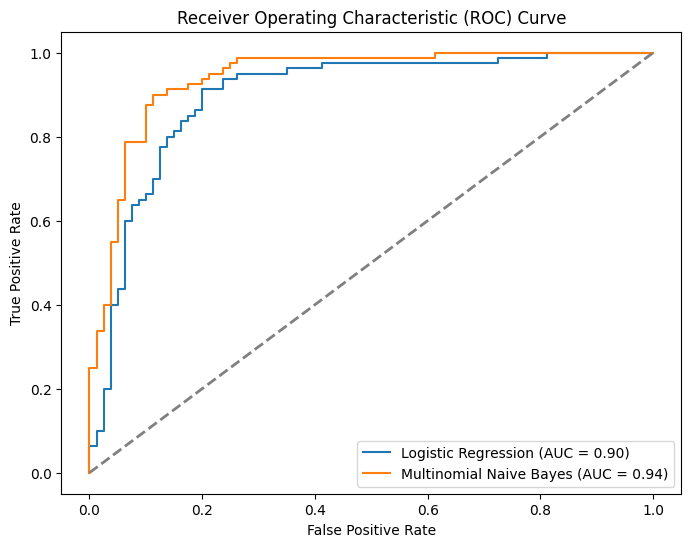

In [87]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import roc_curve, roc_auc_score, auc
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer

# Train a Multinomial Naive Bayes model
nb_classifier = MultinomialNB()
nb_classifier.fit(X_train_tfidf, y_train)

# Calculate ROC curve and AUC for Logistic Regression
logistic_regression_probs = best_logistic_regression.predict_proba(X_test_tfidf)[:, 1]
fpr_lr, tpr_lr, thresholds_lr = roc_curve(y_test, logistic_regression_probs)
auc_lr = auc(fpr_lr, tpr_lr)

# Calculate ROC curve and AUC for Naive Bayes
nb_probs = nb_classifier.predict_proba(X_test_tfidf)[:, 1]
fpr_nb, tpr_nb, thresholds_nb = roc_curve(y_test, nb_probs)
auc_nb = auc(fpr_nb, tpr_nb)

# Plot the ROC curves
plt.figure(figsize=(8, 6))
plt.plot(fpr_lr, tpr_lr, label=f'Logistic Regression (AUC = {auc_lr:.2f})')
plt.plot(fpr_nb, tpr_nb, label=f'Multinomial Naive Bayes (AUC = {auc_nb:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()


###  Is the Random Forest able to improve on the performance of the linear classifiers?

In [88]:
# Calculate accuracy for Logistic Regression
y_pred_lr = best_logistic_regression.predict(X_test_tfidf)
accuracy_lr = accuracy_score(y_test, y_pred_lr)

# Calculate accuracy for Multinomial Naive Bayes
y_pred_nb = nb_classifier.predict(X_test_tfidf)
accuracy_nb = accuracy_score(y_test, y_pred_nb)

# Calculate accuracy for Random Forest
y_pred_rf = best_random_forest.predict(X_test_tfidf)
accuracy_rf = accuracy_score(y_test, y_pred_rf)

print(f'Logistic Regression Accuracy: {accuracy_lr:.2f}')
print(f'Multinomial Naive Bayes Accuracy: {accuracy_nb:.2f}')
print(f'Random Forest Accuracy: {accuracy_rf:.2f}')


Logistic Regression Accuracy: 0.84
Multinomial Naive Bayes Accuracy: 0.83
Random Forest Accuracy: 0.83


### Does performance improve by adding bigram features, instead of using just unigrams?

In [89]:
# Create a TF-IDF vectorizer with bigram features
tfidf_vectorizer_bigram = TfidfVectorizer(ngram_range=(1, 2), max_features=5000, stop_words='english')  # Adjust max_features as needed

# Fit and transform the training data with bigram features
X_train_tfidf_bigram = tfidf_vectorizer_bigram.fit_transform(X_train)

# Transform the testing data with bigram features
X_test_tfidf_bigram = tfidf_vectorizer_bigram.transform(X_test)


### 1. Multinomial naive Bayes BIGRAM

In [90]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

# Create and train the Multinomial Naive Bayes classifier
nb_classifier = MultinomialNB()
nb_classifier.fit(X_train_tfidf_bigram, y_train)

# Make predictions on the test data
y_pred = nb_classifier.predict(X_test_tfidf_bigram)

# Calculate and print the accuracy and classification report
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print("Accuracy:", accuracy)
print("\nClassification Report:\n", report)

Accuracy: 0.88125

Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.89      0.88        80
           1       0.89      0.88      0.88        80

    accuracy                           0.88       160
   macro avg       0.88      0.88      0.88       160
weighted avg       0.88      0.88      0.88       160



### 2. Logistic regression with Lasso penalty BIGRAM

In [91]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.pipeline import Pipeline

# Create a Logistic Regression model
logistic_regression = LogisticRegression(penalty='l1', solver='liblinear', random_state=42)

# Define the hyperparameter grid for grid search
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100]  # Adjust these values as needed
}

# Create a GridSearchCV instance
grid_search = GridSearchCV(logistic_regression, param_grid, cv=5)  # You can adjust the number of cross-validation folds

# Fit the grid search to the training data
grid_search.fit(X_train_tfidf_bigram, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_

# Fit the final model with the best hyperparameters on all training data
best_logistic_regression = LogisticRegression(penalty='l1', solver='liblinear', random_state=42, C=best_params['C'])
best_logistic_regression.fit(X_train_tfidf_bigram, y_train)

# Make predictions on the test data
y_pred = best_logistic_regression.predict(X_test_tfidf_bigram)

# Calculate and print the accuracy and classification report
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print("Best Hyperparameters:", best_params)
print("Accuracy:", accuracy)
print("\nClassification Report:\n", report)

Best Hyperparameters: {'C': 100}
Accuracy: 0.7875

Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.76      0.78        80
           1       0.77      0.81      0.79        80

    accuracy                           0.79       160
   macro avg       0.79      0.79      0.79       160
weighted avg       0.79      0.79      0.79       160



### 3. Classification trees BIGRAM

In [92]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

# Create a Decision Tree model
decision_tree = DecisionTreeClassifier(random_state=42)

# Define hyperparameter grid for grid search
param_grid = {
    'ccp_alpha': [0.001, 0.01, 0.1, 1]  # Adjust these values as needed
}

# Perform grid search with cross-validation
grid_search = GridSearchCV(decision_tree, param_grid, cv=10)  # You can change the number of folds (cv) as needed

# Fit the model to the training data
grid_search.fit(X_train_tfidf, y_train)

# Best hyperparameters
best_params = grid_search.best_params_

# Fit the final model with the best hyperparameters on all training data
best_decision_tree = grid_search.best_estimator_
best_decision_tree.fit(X_train_tfidf_bigram, y_train)

# Make predictions on the test data
y_pred = best_decision_tree.predict(X_test_tfidf_bigram)

# Evaluate the model and print results
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print("Best Hyperparameters:", best_params)
print("Accuracy:", accuracy)
print("\nClassification Report:\n", report)

Best Hyperparameters: {'ccp_alpha': 0.01}
Accuracy: 0.6625

Classification Report:
               precision    recall  f1-score   support

           0       0.68      0.62      0.65        80
           1       0.65      0.70      0.67        80

    accuracy                           0.66       160
   macro avg       0.66      0.66      0.66       160
weighted avg       0.66      0.66      0.66       160



### 4. Random forests BIGRAM

In [93]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Create a Random Forest model
random_forest = RandomForestClassifier(random_state=42, oob_score=True)

# Define hyperparameter grid for grid search
param_grid = {
    'n_estimators': [100, 200, 300],  # Adjust these values as needed
    'max_features': ['sqrt', 'log2']  # Adjust these values as needed
}

# Perform grid search with cross-validation
grid_search = GridSearchCV(random_forest, param_grid, cv=10)  # You can change the number of folds (cv) as needed

# Fit the model to the training data
grid_search.fit(X_train_tfidf_bigram, y_train)

# Best hyperparameters
best_params = grid_search.best_params_

# Fit the final model with the best hyperparameters on all training data
best_random_forest = grid_search.best_estimator_
best_random_forest.fit(X_train_tfidf_bigram, y_train)

# Make predictions on the test data
y_pred = best_random_forest.predict(X_test_tfidf_bigram)

# Evaluate the model and print results
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print("Best Hyperparameters:", best_params)
print("Accuracy:", accuracy)
print("\nClassification Report:\n", report)
print("Out-of-Bag Score:", best_random_forest.oob_score_)


Best Hyperparameters: {'max_features': 'sqrt', 'n_estimators': 100}
Accuracy: 0.8

Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.78      0.79        80
           1       0.79      0.82      0.80        80

    accuracy                           0.80       160
   macro avg       0.80      0.80      0.80       160
weighted avg       0.80      0.80      0.80       160

Out-of-Bag Score: 0.809375


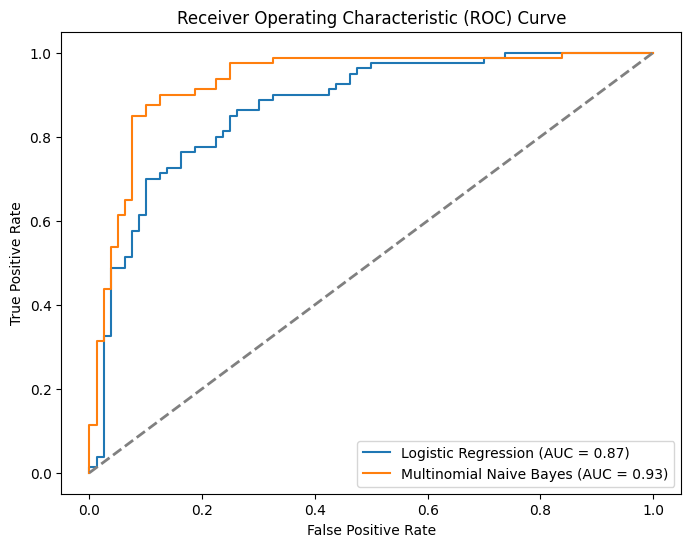

In [94]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import roc_curve, roc_auc_score, auc
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer

# Train a Multinomial Naive Bayes model
nb_classifier = MultinomialNB()
nb_classifier.fit(X_train_tfidf_bigram, y_train)

# Calculate ROC curve and AUC for Logistic Regression
logistic_regression_probs = best_logistic_regression.predict_proba(X_test_tfidf_bigram)[:, 1]
fpr_lr, tpr_lr, thresholds_lr = roc_curve(y_test, logistic_regression_probs)
auc_lr = auc(fpr_lr, tpr_lr)

# Calculate ROC curve and AUC for Naive Bayes
nb_probs = nb_classifier.predict_proba(X_test_tfidf_bigram)[:, 1]
fpr_nb, tpr_nb, thresholds_nb = roc_curve(y_test, nb_probs)
auc_nb = auc(fpr_nb, tpr_nb)

# Plot the ROC curves
plt.figure(figsize=(8, 6))
plt.plot(fpr_lr, tpr_lr, label=f'Logistic Regression (AUC = {auc_lr:.2f})')
plt.plot(fpr_nb, tpr_nb, label=f'Multinomial Naive Bayes (AUC = {auc_nb:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()


### What are the five most important terms (features) pointing towards a fake review? 
### What are the five most important terms (features) pointing towards a genuine review?

In [95]:
from sklearn.naive_bayes import MultinomialNB

for x in range(0,2):
    # Specify the class for which you want to retrieve the top features
    target_class = x  # Replace with the desired class index

    feature_log_probabilities = nb_classifier.feature_log_prob_

    # Retrieve the feature names (e.g., words or tokens)
    feature_names = tfidf_vectorizer_bigram.get_feature_names_out()  # Replace with your vectorizer


    # Sort the feature log probabilities for the specified class
    class_feature_log_probs = feature_log_probabilities[target_class]

    # Combine the TF-IDF values and feature names
    class_feature_tfidf = list(zip(class_feature_log_probs, feature_names))

    # Sort the features by their TF-IDF values (higher values are more indicative)
    sorted_features = sorted(class_feature_tfidf, reverse=True)

    # Specify the number of top features you want to retrieve
    top_n = 5  # Replace with the desired number of top features

    # Get the top N feature names for the specified class
    top_features = [feature for _, feature in sorted_features[:top_n]]

    print("Class {}: {}".format(target_class, top_features))

Class 0: ['chicago', 'stay', 'room', 'service', 'like']
Class 1: ['stay', 'staff', 'great', 'service', 'night']


In [96]:
# Get the coefficients (weights) from the logistic regression model
coefficients = best_logistic_regression.coef_

# Get the feature names (e.g., words or terms) from the TF-IDF vectorizer
feature_names = tfidf_vectorizer.get_feature_names_out()

# Create lists to store features associated with each class
class_0_features = []
class_1_features = []

# Iterate through the coefficients and feature names
for coef, feature in zip(coefficients[0], feature_names):
    if coef < 0:  # Negative coefficients are associated with class 0 (genuine reviews)
        class_0_features.append((feature, -coef))  # Use -coef to make it positive
    else:
        class_1_features.append((feature, coef))

# Sort the features by the absolute value of their coefficients
class_0_features.sort(key=lambda x: x[1], reverse=True)
class_1_features.sort(key=lambda x: x[1], reverse=True)

# Print the top features for each class
print("Top features for class 0 (genuine reviews):")
for feature, coef in class_0_features[:5]:  # Change the number to get more or fewer features
    print(f"{feature}: {coef:.4f}")

print("\nTop features for class 1 (fake reviews):")
for feature, coef in class_1_features[:5]:  # Change the number to get more or fewer features
    print(f"{feature}: {coef:.4f}")


Top features for class 0 (genuine reviews):
comes: 59.6347
scampering: 28.5918
pick: 27.9085
scale: 25.9846
street: 25.5440

Top features for class 1 (fake reviews):
quotes: 28.4174
surcharge: 27.5039
sheen: 25.9796
dc: 24.7865
renamed: 21.5462
